### EDA Profiling - Parte 2

In [2]:
## Usamos el mismo dataset de la parte 1 para hacer EDA profiling (no hay modificaciones en los datos)

import pandas as pd

train_df = pd.read_csv("/Users/luanagiusto/TP-1-ML/entrenamiento.csv")

ModuleNotFoundError: No module named 'pandas'

Genero un mapa para visualizar los datos

In [11]:
import pandas as pd
import numpy as np
import folium

# ========= 0) Helpers
def to_float(s):
    # Convierte "−34,6037" -> -34.6037 y maneja strings
    if pd.isna(s):
        return np.nan
    if isinstance(s, (int, float, np.number)):
        return float(s)
    s = str(s).strip().replace(",", ".")
    try:
        return float(s)
    except:
        return np.nan

# Bounding box aproximado de Argentina
LAT_MIN, LAT_MAX = -56.0, -21.0
LON_MIN, LON_MAX = -75.0, -53.0

def in_argentina(lat, lon):
    return (LAT_MIN <= lat <= LAT_MAX) and (LON_MIN <= lon <= LON_MAX)

# ========= 1) Limpieza de lat/lon
train_df["lat"] = train_df["lat"].apply(to_float)
train_df["lon"] = train_df["lon"].apply(to_float)

# elimina NaN
geo = train_df.dropna(subset=["lat", "lon"]).copy()

# ========= 2) Corregir lat/lon invertidas fila a fila
# Si (lat, lon) NO cae en AR pero (lon, lat) SÍ cae, entonces invertir
mask_swap = (~geo.apply(lambda r: in_argentina(r["lat"], r["lon"]), axis=1)) & \
            ( geo.apply(lambda r: in_argentina(r["lon"], r["lat"]), axis=1))

geo.loc[mask_swap, ["lat", "lon"]] = geo.loc[mask_swap, ["lon", "lat"]].values

# ========= 3) Filtrar por bounding box de Argentina (quita outliers)
geo = geo[geo.apply(lambda r: in_argentina(r["lat"], r["lon"]), axis=1)].copy()

# ========= 4) Muestreo de 10.000 puntos (sin clúster)
if len(geo) > 10_000:
    geo = geo.sample(n=10_000, random_state=42)

# Nombre para tooltip si no existe
if "localidad" not in geo.columns:
    # Probamos usar l2/l3 como etiqueta si existen; si no, el índice
    if "l3" in geo.columns:
        geo["localidad"] = geo["l3"].fillna(geo.get("l2", "")).fillna("").replace("", np.nan)
    elif "l2" in geo.columns:
        geo["localidad"] = geo["l2"]
    else:
        geo["localidad"] = "prop_" + geo.index.astype(str)

    geo["localidad"] = geo["localidad"].fillna("prop_" + geo.index.astype(str))

# ========= 5) Crear mapa y dibujar puntos (uno a uno, SIN agrupamiento)
center = [geo["lat"].mean(), geo["lon"].mean()]
m = folium.Map(location=center, zoom_start=5, tiles="CartoDB positron")

for _, r in geo.iterrows():
    tooltip = str(r["localidad"])
    popup = folium.Popup(
        f"<b>{tooltip}</b><br>Lat: {r['lat']:.6f}<br>Lon: {r['lon']:.6f}",
        max_width=260
    )
    folium.CircleMarker(
        location=[r["lat"], r["lon"]],  # OJO: folium espera [lat, lon]
        radius=3,
        fill=True,
        fill_opacity=0.8,
        weight=0.5,
        popup=popup,
        tooltip=tooltip
    ).add_to(m)

m.save("mapa_propiedades_sin_cluster.html")
print("OK → mapa_propiedades_sin_cluster.html")

TypeError: "value" parameter must be a scalar, dict or Series, but you passed a "Index"

### 1. Overview of entrenamiento.csv

In [12]:
print('Shape:', train_df.shape)
print('Columns:', train_df.columns.tolist())
print(train_df.dtypes)


Shape: (992192, 25)
Columns: ['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'currency', 'price_period', 'title', 'description', 'property_type', 'operation_type', 'price']
id                   int64
ad_type             object
start_date          object
end_date            object
created_on          object
lat                float64
lon                float64
l1                  object
l2                  object
l3                  object
l4                  object
l5                  object
l6                 float64
rooms              float64
bedrooms           float64
bathrooms          float64
surface_total      float64
surface_covered    float64
currency            object
price_period        object
title               object
description         object
property_type       object
operation_type      object
price              float64
dtype: object


### 2. Missing Values Analysis

In [13]:
missing = train_df.isnull().sum().sort_values(ascending=False)
print(missing[missing > 0])


l6                 992192
l5                 987481
l4                 766797
price_period       622253
bedrooms           601493
surface_covered    555231
surface_total      544028
rooms              489147
bathrooms          219171
lat                153198
lon                152263
l3                  57455
currency            47251
price               44381
title                  28
description            22
dtype: int64


### 3. Descriptive Statistics

In [14]:
print(train_df.describe(include='all'))


                    id    ad_type  start_date    end_date  created_on  \
count    992192.000000     992192      992192      992192      992192   
unique             NaN          1         346         450         346   
top                NaN  Propiedad  2020-03-21  9999-12-31  2020-03-21   
freq               NaN     992192       13161      191147       13161   
mean     500338.438758        NaN         NaN         NaN         NaN   
std      288685.497758        NaN         NaN         NaN         NaN   
min           1.000000        NaN         NaN         NaN         NaN   
25%      250259.750000        NaN         NaN         NaN         NaN   
50%      500641.500000        NaN         NaN         NaN         NaN   
75%      750507.250000        NaN         NaN         NaN         NaN   
max     1000000.000000        NaN         NaN         NaN         NaN   

                  lat            lon         l1               l2  \
count   838994.000000  839929.000000     992192        

### 4. Value Counts for Categorical Columns

In [15]:
categorical_cols = train_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f'\nValue counts for {col}:')
    print(train_df[col].value_counts(dropna=False).head(10))



Value counts for ad_type:
ad_type
Propiedad    992192
Name: count, dtype: int64

Value counts for start_date:
start_date
2020-03-21    13161
2020-04-21    13063
2020-02-25    13018
2019-08-01    11081
2020-02-27    10330
2020-04-08    10020
2020-01-09     9942
2020-04-29     9211
2020-03-18     8451
2020-03-13     8402
Name: count, dtype: int64

Value counts for end_date:
end_date
9999-12-31    191147
2020-04-28     75472
2020-04-27     20937
2019-12-23     19067
2019-08-14     14359
2020-06-01     11855
2020-06-25     10565
2020-02-19      9711
2020-02-13      9049
2020-09-23      8567
Name: count, dtype: int64

Value counts for created_on:
created_on
2020-03-21    13161
2020-04-21    13063
2020-02-25    13018
2019-08-01    11081
2020-02-27    10330
2020-04-08    10020
2020-01-09     9942
2020-04-29     9211
2020-03-18     8451
2020-03-13     8402
Name: count, dtype: int64

Value counts for l1:
l1
Argentina         973422
Uruguay            17929
Estados Unidos       783
Brasil      

### 5. Distribution Plots for Key Numerical Columns

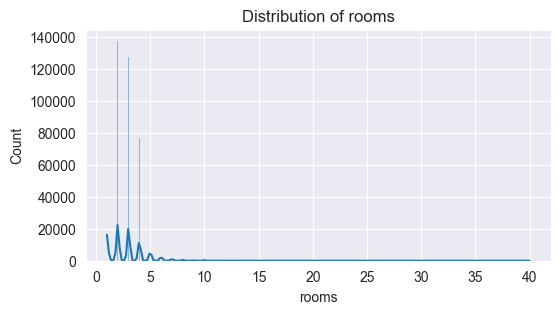

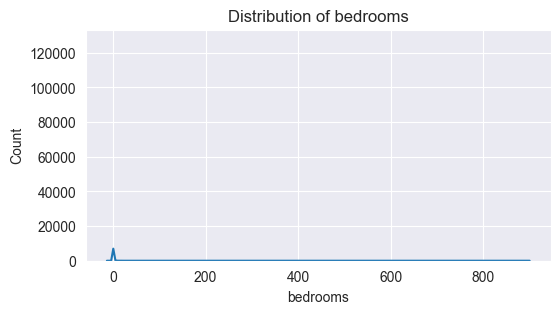

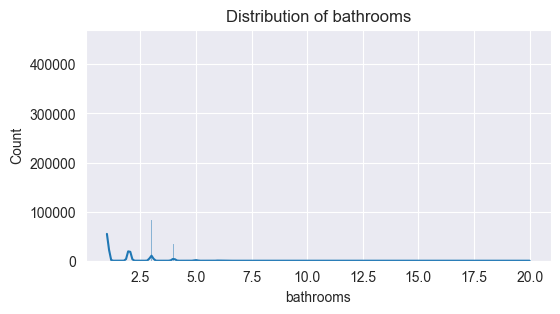

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
num_cols = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']
for col in num_cols:
    if col in train_df.columns:
        plt.figure(figsize=(6, 3))
        sns.histplot(train_df[col].dropna(), kde=True)
        plt.title(f'Distribution of {col}')
        plt.show()


### 6. Correlation Matrix

In [1]:
plt.figure(figsize=(8, 6))
sns.heatmap(train_df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


NameError: name 'plt' is not defined